Predicting future customer preferences to enhance customer satisfaction and increase sales. To unearth the hidden niche movie products.

In [1]:
#loading the movie dataset into a pandas dataframe
import pandas as pd
df1=pd.read_csv('movies.csv')
print(df1.shape)
#display the data types of columns
print(df1.dtypes)
df1.head()


(9742, 3)
movieId     int64
title      object
genres     object
dtype: object


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
#loading the ratings dataset into a pandas dataframe
df2=pd.read_csv('ratings.csv')
print(df2.shape)
#display the data types of columns
print(df2.dtypes)
df2.head()


(100836, 4)
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
#loading the tags dataset into a pandas dataframe
df3=pd.read_csv('tags.csv')
print(df3.shape)
#display the data types of columns
print(df3.dtypes)
df3.head()


(3683, 4)
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
# Checking for missing values in each column of df1
df1.isna().sum()


movieId    0
title      0
genres     0
dtype: int64

In [5]:
# Checking for missing values in each column of df2
df2.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
# Checking for missing values in each column of df3
df3.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

From the above we note that they are no missing values in the datasets

###### Distribution of movie ratings

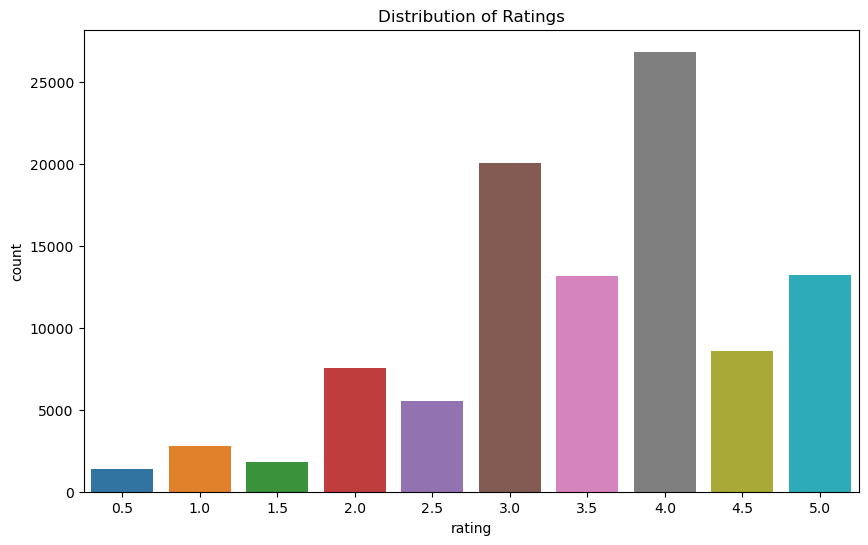

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df2)
plt.title('Distribution of Ratings')
plt.show()

The movie rating obtained from the dataset ranges from 0.5 to 5.0 with a majority of movies rated 4.0

In [8]:
#merging the movies dataset(df1) and rating dataset(df2)
merged_dataset = pd.merge(df1, df2, how='inner', on='movieId')
merged_dataset.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [9]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [10]:
# Drop unnecessary columns
merged_dataset = merged_dataset.drop(columns='timestamp')

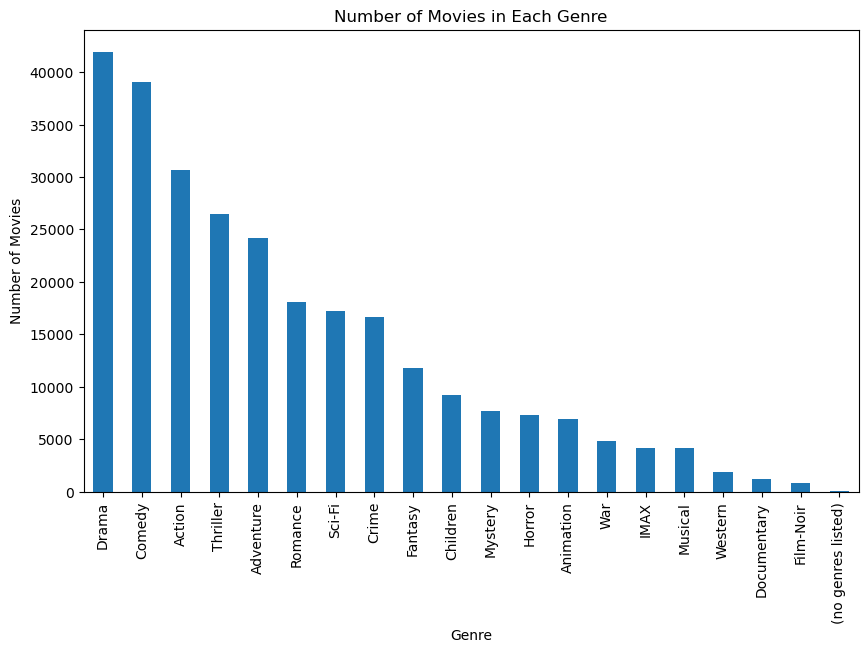

In [11]:
#plot the count of movies per genre 
import pandas as pd
import matplotlib.pyplot as plt

genres_series = merged_dataset['genres'].str.split('|', expand=True).stack()
genre_counts = genres_series.value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

From the above bar plot,most movies in the dataset belong to the drama genre

##### Computing SVD (Singular Value Decomposition) 

In [12]:
#importing libraries
from surprise import SVD
from surprise import Dataset,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split,GridSearchCV
import numpy as np

In [13]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Define the expected column names
expected_column_names = ["userId", "movieId", "rating"]

# Load the data into a Surprise Dataset
data_surp = Dataset.load_from_df(merged_dataset[expected_column_names], reader)
data_surp

In [14]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data_surp, test_size=0.2)

In [15]:
#Initializing the SVD algorithm
model = SVD()

#Fitting the model 
model.fit(trainset)

In [16]:
#making prediction
prediction = model.test(testset)
#compute the error
accuracy.rmse(prediction)

RMSE: 0.8775


0.8774639725496257

A RMSE value of 0.8747 suggests that, on average, the predicted ratings deviate by approximately 0.8747 units from the true ratings.

In [17]:
#predicting rating for a user for a movie and giving recommendation
uid = str(456) #user id
iid = str(131) #movieid

#get a prediction for specific user and item
pred = model.predict(uid,iid)
#viewing the predicted rating
pred.est

3.5016177418555063

###### Hyperparameter tuning using GridSearchCV 

In [18]:
# Define the parameter grid
param_grid = {'n_factors': [50, 100, 150],
              'n_epochs': [20, 30, 40],
              'lr_all': [0.005, 0.01, 0.02],
              'reg_all': [0.02, 0.1, 0.2]}

# Initialize the SVD algorithm
model = SVD()

# Initialize GridSearchCV with the SVD algorithm and parameter grid
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Perform grid search
grid_search.fit(data_surp)

# Get the best RMSE score
best_rmse = grid_search.best_score['rmse']

# Get the best parameters
best_params = grid_search.best_params['rmse']

print("RMSE:", best_rmse)
print("Parameters:", best_params)


RMSE: 0.8595744542562743
Parameters: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.02, 'reg_all': 0.1}


In [19]:
trainset, testset = train_test_split(data_surp, test_size=0.2)

model = SVD(**best_params)
model.fit(trainset)
predictions = model.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8584
0.8583881589001874


In [20]:
#predicting rating for a user for a movie and giving recommendation
uid = str(456) #user id
iid = str(131) #movieid

#get a prediction for specific user and item
pred = model.predict(uid,iid)
#viewing the predicted rating
pred.est

3.5027706153617295

In [29]:
# Get all unique movie IDs
all_movie_ids = np.unique(merged_dataset['movieId'])

# User ID for which we want to predict ratings
user_id = str(456)

# Predict ratings for each movie for the given user
predicted_ratings = []

for movie_id in all_movie_ids:
    pred = model.predict(user_id, str(movie_id)).est
    predicted_ratings.append((movie_id, pred))

# Display the top predicted ratings
top_n = 10  # Number of top recommendations to display
top_recommendations = predicted_ratings[:top_n]

for movie_id, predicted_rating in top_recommendations:
    # You can fetch additional information about the movie from your dataset
    movie_title = merged_dataset.loc[merged_dataset['movieId'] == movie_id, 'title'].iloc[0]
    print(f"Movie ID: {movie_id}, Title: {movie_title}, Predicted Rating: {predicted_rating}")

Movie ID: 1, Title: Toy Story (1995), Predicted Rating: 3.5027706153617295
Movie ID: 2, Title: Jumanji (1995), Predicted Rating: 3.5027706153617295
Movie ID: 3, Title: Grumpier Old Men (1995), Predicted Rating: 3.5027706153617295
Movie ID: 4, Title: Waiting to Exhale (1995), Predicted Rating: 3.5027706153617295
Movie ID: 5, Title: Father of the Bride Part II (1995), Predicted Rating: 3.5027706153617295
Movie ID: 6, Title: Heat (1995), Predicted Rating: 3.5027706153617295
Movie ID: 7, Title: Sabrina (1995), Predicted Rating: 3.5027706153617295
Movie ID: 8, Title: Tom and Huck (1995), Predicted Rating: 3.5027706153617295
Movie ID: 9, Title: Sudden Death (1995), Predicted Rating: 3.5027706153617295
Movie ID: 10, Title: GoldenEye (1995), Predicted Rating: 3.5027706153617295
